In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.coordinates as coord
from astropy.time import Time
from astropy import units as u
from tqdm import tqdm

In [2]:
pd.set_option('display.precision',30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Load up Gaia results
#### (see adql_query.txt for query)

In [3]:
gaia = np.genfromtxt('../hjhosts-result.csv', delimiter=',', unpack=True, names=True, dtype=None, encoding=None)

In [4]:
table = pd.DataFrame.from_records(gaia)

In [5]:
table = table.rename(columns={'col1':'kep_ra', 'col2':'kep_dec', 'col3':'kepmag', 'col4':'kepid'})

#### Calculate better angular separations that take propagated proper motion into account:

In [6]:
refCoord = coord.SkyCoord(ra=table['kep_ra'].values * u.degree, 
                          dec=table['kep_dec'].values * u.degree)        

In [7]:
table['radial_velocity'][np.isnan(table['radial_velocity'])] = 0.
gaia_time = Time(table['ref_epoch'], format='jyear')
kepler_time = Time(2004, format='jyear') # GUESS
gaiaCoord = coord.SkyCoord(ra=table['ra'].values * u.degree, 
                           dec=table['dec'].values * u.degree, 
                           distance=(np.zeros_like(table['ra'].values) + 100.) * u.kpc, # HACK
                           radial_velocity=np.zeros_like(table['ra'].values) * u.km / u.s, # HACK
                           pm_ra_cosdec=table['pmra'].values * u.milliarcsecond / u.year, 
                           pm_dec=table['pmdec'].values * u.milliarcsecond / u.year, 
                           obstime=gaia_time
                            )
gaiaCoord_shifted = gaiaCoord.apply_space_motion(new_obstime=kepler_time)
sep = refCoord.separation(gaiaCoord_shifted)
#ind = np.where(sep > 10. * u.deg)[0]
#for i in ind:
#        sep[i] = 180.*u.deg - sep[i] # HACK

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/distances.py:162: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:639: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-package

In [8]:
table['ang_dist_w_pm'] = sep.arcsec

In [9]:
table['ra_keptime'] = gaiaCoord_shifted.ra.degree
table['dec_keptime'] = gaiaCoord_shifted.dec.degree

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:639: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:639: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_

Check on the best matches:

In [10]:
matches = table.sort_values(['kepid', 'ang_dist_w_pm'], inplace=False)
matches.drop_duplicates('kepid', inplace=True)

(array([256.,   1.,   0.,   3.,   0.,   1.,   0.,   0.,   0.,   2.]),
 array([3.61220437e-03, 1.77017480e+00, 3.53673739e+00, 5.30329998e+00,
        7.06986257e+00, 8.83642516e+00, 1.06029878e+01, 1.23695503e+01,
        1.41361129e+01, 1.59026755e+01, 1.76692381e+01]),
 <a list of 10 Patch objects>)

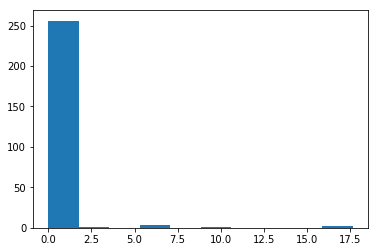

In [11]:
plt.hist(matches['ang_dist_w_pm'])

In [12]:
matches[matches['ang_dist_w_pm'] > 5.]

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,epoch_photometry_url,hjhosts_oid,kep_ra,kep_dec,kepmag,kepid,ang_dist,ang_dist_w_pm,ra_keptime,dec_keptime
23910,1635721458409799680,Gaia DR2 2101508501301082368,2101508501301082368,1004772443,2015.500,291.284,0.027,40.728,0.038,0.383,...,,115,291.285,40.730,15.855,5531953,0.003,8.981,291.284,40.728
43979,1635721458409799680,Gaia DR2 2076660672388510464,2076660672388510464,1039014877,2015.500,294.960,0.072,40.985,0.098,0.100,...,,208,294.960,40.987,15.423,5716244,0.002,5.842,294.960,40.985
48799,1635721458409799680,Gaia DR2 2080091492257542144,2080091492257542144,325514623,2015.500,294.994,0.206,46.224,0.213,0.269,...,,234,294.991,46.224,14.538,9596187,0.002,6.591,294.994,46.224
18147,1635721458409799680,Gaia DR2 2086324275778825600,2086324275778825600,184412114,2015.500,297.653,0.211,47.167,0.206,0.154,...,,90,297.646,47.167,13.592,10158418,0.005,16.706,297.653,47.167
21791,1635721458409799680,Gaia DR2 2130856356427181568,2130856356427181568,349879453,2015.500,287.707,0.324,47.334,0.559,0.028,...,,104,287.709,47.333,12.128,10264660,0.002,5.525,287.707,47.334
39409,1635721458409799680,Gaia DR2 2119616182197267200,2119616182197267200,981221805,2015.500,281.772,0.146,47.598,0.166,0.227,...,,191,281.776,47.593,14.371,10384962,0.005,17.669,281.773,47.598


In [13]:
from utils import *

In [14]:
kepids = np.unique(table['kepid'].values)

In [ ]:
columns = ['kic_primary','gaia_id_primary', 'gaia_id_match', 'ra_match_keptime', 
           'dec_match_keptime', 'ra_match_gaia', 'dec_match_gaia', 'gaiamag_match', 'chisq']
matches_table = pd.DataFrame(columns=columns)

In [ ]:
def add_to_matches_table(match, primary, chisq, matches_table):
    chisq_nonzero1 = calc_chisq_nonzero(primary)
    chisq_nonzero2 = calc_chisq_nonzero(match)
    matches_table = matches_table.append({'kic_primary': primary['kepid'], 
                          'gaia_id_primary': primary['source_id'], 
                          'gaia_id_match': match['source_id'], 
                          'ra_match_keptime': match['ra_keptime'], 
                          'dec_match_keptime': match['dec_keptime'], 
                          'ra_match_gaia': match['ra'],
                          'dec_match_gaia': match['dec'],
                          'gaiamag_match': match['phot_g_mean_mag'],
                          'chisq': chisq,
                          'chisq_zeropm_primary': chisq_nonzero1,
                          'chisq_zeropm_match': chisq_nonzero2}, ignore_index=True)
    return matches_table

In [ ]:
for k in tqdm(kepids):
    temp = table[table['kepid'] == k]
    best_match = temp.loc[temp['ang_dist_w_pm'].idxmin()]
    chisq_nonzero1 = calc_chisq_nonzero(best_match)
    if (best_match['ang_dist_w_pm'] > 1.): # arbitrary
        continue
    other_matches = temp.drop(temp['ang_dist_w_pm'].idxmin())
    chisqs = other_matches.apply(calc_chisq_for_pair, axis=1, args=(best_match,))
    for o,c in zip(other_matches.iterrows(), chisqs):
        if c > 0.:
            matches_table = add_to_matches_table(o[1], best_match, c, matches_table)

In [ ]:
len(matches_table)

In [ ]:
matches_table.to_csv('matches.csv', index=False)

In [15]:
#matches_table = np.genfromtxt('matches.csv', delimiter=',', names=True, dtype=None, encoding=None)
#matches_table = pd.DataFrame(matches_table)

In [ ]:
plt.hist(matches_table['chisq'])

In [16]:
np.sum((matches_table['chisq_zeropm_primary'] > 25.) & (matches_table['chisq_zeropm_match'] > 25.))

4804

In [20]:
good_matches_table = matches_table[(matches_table['chisq_zeropm_primary'] > 25.) & 
                                   (matches_table['chisq_zeropm_match'] > 25.) &
                                   (matches_table['chisq'] < 10.)]
good_matches_table.to_csv('good_matches.csv')

In [32]:
len(good_matches_table)

1354

In [30]:
ind = np.random.choice(good_matches_table.index)
star1 = table[table['source_id'] == good_matches_table['gaia_id_match'][ind]]
star2 = table[table['source_id'] == good_matches_table['gaia_id_primary'][ind]]

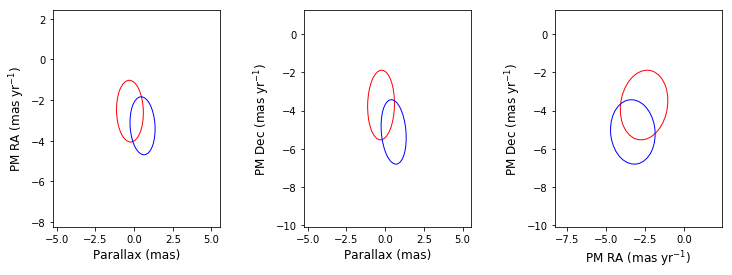

In [31]:
plot_xs(star1, star2, sigma=3)

### Now do it all again for K2:

In [33]:
gaia = np.genfromtxt('../hjhosts_k2-result.csv', delimiter=',', unpack=True, names=True, dtype=None, encoding=None)

In [34]:
table = pd.DataFrame.from_records(gaia)
table = table.rename(columns={'col1':'kep_ra', 'col2':'kep_dec', 'col3':'kepmag', 'col4':'epic_number'})

In [35]:
refCoord = coord.SkyCoord(ra=table['kep_ra'].values * u.degree, 
                          dec=table['kep_dec'].values * u.degree)        

In [36]:
table['radial_velocity'][np.isnan(table['radial_velocity'])] = 0.
gaia_time = Time(table['ref_epoch'], format='jyear')
kepler_time = Time('J2000') # GUESS
gaiaCoord = coord.SkyCoord(ra=table['ra'].values * u.degree, 
                           dec=table['dec'].values * u.degree, 
                           distance=(np.zeros_like(table['ra'].values) + 100.) * u.kpc, # HACK
                           radial_velocity=np.zeros_like(table['ra'].values) * u.km / u.s, # HACK
                           pm_ra_cosdec=table['pmra'].values * u.milliarcsecond / u.year, 
                           pm_dec=table['pmdec'].values * u.milliarcsecond / u.year, 
                           obstime=gaia_time
                            )
gaiaCoord_shifted = gaiaCoord.apply_space_motion(new_obstime=kepler_time)
sep = refCoord.separation(gaiaCoord_shifted)

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/distances.py:162: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:639: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-package

In [37]:
table['ang_dist_w_pm'] = sep.arcsec

In [38]:
table['ra_keptime'] = gaiaCoord_shifted.ra.degree
table['dec_keptime'] = gaiaCoord_shifted.dec.degree

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:639: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/coordinates/angles.py:639: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_

(array([138.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.51226504e-03, 4.78119742e+00, 9.55988258e+00, 1.43385677e+01,
        1.91172529e+01, 2.38959380e+01, 2.86746232e+01, 3.34533084e+01,
        3.82319935e+01, 4.30106787e+01, 4.77893638e+01]),
 <a list of 10 Patch objects>)

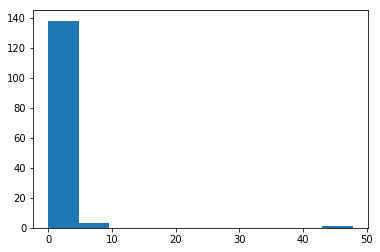

In [39]:
matches = table.sort_values(['epic_number', 'ang_dist_w_pm'], inplace=False)
matches.drop_duplicates('epic_number', inplace=True)
plt.hist(matches['ang_dist_w_pm'])

In [40]:
epic_numbers = np.unique(table['epic_number'].values)
matches_table = pd.DataFrame()

In [41]:
def add_to_matches_table(match, primary, chisq, matches_table):
    chisq_nonzero1 = calc_chisq_nonzero(primary)
    chisq_nonzero2 = calc_chisq_nonzero(match)
    matches_table = matches_table.append({'epic_primary': primary['epic_number'], 
                          'gaia_id_primary': primary['source_id'], 
                          'gaia_id_match': match['source_id'], 
                          'ra_match_keptime': match['ra_keptime'], 
                          'dec_match_keptime': match['dec_keptime'], 
                          'ra_match_gaia': match['ra'],
                          'dec_match_gaia': match['dec'],
                          'gaiamag_match': match['phot_g_mean_mag'],
                          'chisq': chisq,
                          'chisq_zeropm_primary': chisq_nonzero1,
                          'chisq_zeropm_match': chisq_nonzero2}, ignore_index=True)
    return matches_table

In [42]:
for k in tqdm(epic_numbers):
    temp = table[table['epic_number'] == k]
    best_match = temp.loc[temp['ang_dist_w_pm'].idxmin()]
    if (best_match['ang_dist_w_pm'] > 4.): # arbitrary
        continue
    other_matches = temp.drop(temp['ang_dist_w_pm'].idxmin())
    chisqs = other_matches.apply(calc_chisq_for_pair, axis=1, args=(best_match,))
    for o,c in zip(other_matches.iterrows(), chisqs):
        if c > 0.:
            matches_table = add_to_matches_table(o[1], best_match, c, matches_table)

100%|██████████| 142/142 [01:02<00:00,  2.26it/s]


In [43]:
matches_table.to_csv('matches_k2.csv')

In [44]:
len(matches_table)

2427

In [45]:
good_matches_table = matches_table[(matches_table['chisq_zeropm_primary'] > 25.) & 
                                   (matches_table['chisq_zeropm_match'] > 25.) &
                                   (matches_table['chisq'] < 10.)]
good_matches_table.to_csv('good_matches_k2.csv')

In [46]:
len(good_matches_table)

143

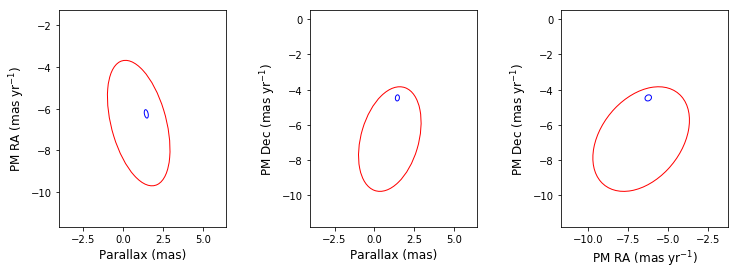

In [48]:
ind = np.random.choice(good_matches_table.index)
star1 = table[table['source_id'] == good_matches_table['gaia_id_match'][ind]]
star2 = table[table['source_id'] == good_matches_table['gaia_id_primary'][ind]]
plot_xs(star1, star2, sigma=3)